# About Dataset

**Attribute Information:**

This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:
- X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
- X2: Gender (1 = male; 2 = female).
- X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
- X4: Marital status (1 = married; 2 = single; 3 = others).
- X5: Age (year).
- X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
- X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
- X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.

# Spark

## Import Dataset

In [191]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("how to read csv file") \
    .getOrCreate()

raw_df = spark.read.csv('./data/credit_card_clients.csv', header=True)
raw_df.show(5)

+---+------+---+---+---+---+---+---+---+---+---+---+-----+-----+-----+-----+-----+-----+----+-----+-----+----+----+----+---+
| ID|    X1| X2| X3| X4| X5| X6| X7| X8| X9|X10|X11|  X12|  X13|  X14|  X15|  X16|  X17| X18|  X19|  X20| X21| X22| X23|  Y|
+---+------+---+---+---+---+---+---+---+---+---+---+-----+-----+-----+-----+-----+-----+----+-----+-----+----+----+----+---+
|  1| 20000|  2|  2|  1| 24|  2|  2| -1| -1| -2| -2| 3913| 3102|  689|    0|    0|    0|   0|  689|    0|   0|   0|   0|  1|
|  2|120000|  2|  2|  2| 26| -1|  2|  0|  0|  0|  2| 2682| 1725| 2682| 3272| 3455| 3261|   0| 1000| 1000|1000|   0|2000|  1|
|  3| 90000|  2|  2|  2| 34|  0|  0|  0|  0|  0|  0|29239|14027|13559|14331|14948|15549|1518| 1500| 1000|1000|1000|5000|  0|
|  4| 50000|  2|  2|  1| 37|  0|  0|  0|  0|  0|  0|46990|48233|49291|28314|28959|29547|2000| 2019| 1200|1100|1069|1000|  0|
|  5| 50000|  1|  2|  1| 57| -1|  0| -1|  0|  0|  0| 8617| 5670|35835|20940|19146|19131|2000|36681|10000|9000| 689| 679|  0|


In [193]:
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler

# change columns type 'str' to 'float' because VectorAssembler are not support to string type
raw_df = raw_df.select(*(col(c).cast("float").alias(c) for c in raw_df.columns))

# get columns name
numericCols = raw_df.drop('ID', 'Y').columns

# merge all feature columns to Vector
assembler = VectorAssembler(inputCols=numericCols, outputCol="features")

va_df = assembler.transform(raw_df)

va_df.select(va_df.features, va_df.Y).show(5)

+--------------------+---+
|            features|  Y|
+--------------------+---+
|[20000.0,2.0,2.0,...|1.0|
|[120000.0,2.0,2.0...|1.0|
|[90000.0,2.0,2.0,...|0.0|
|[50000.0,2.0,2.0,...|0.0|
|[50000.0,1.0,2.0,...|0.0|
+--------------------+---+
only showing top 5 rows



In [194]:
# train/test split
bs_train, bs_test = va_df.randomSplit([0.7, 0.3], seed=0)

train = bs_train.select(['features', 'Y'])
test = bs_test.select(['features', 'Y'])

In [202]:
from pyspark.ml.classification import RandomForestClassifier
import time

# Define model
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'Y')

# Train the model
model_training_start_time = time.perf_counter()
rf = rf.fit(train)
model_training_elapsed_time =  time.perf_counter() - model_training_start_time 
print(f'Model Training Time in Seconds: {model_training_elapsed_time}')

# Prediction
model_prediction_start_time = time.perf_counter()
pred = rf.transform(test)
model_prediction_elapsed_time = time.perf_counter() - model_prediction_start_time
print(f'Model Prediction Time in Seconds: {model_prediction_elapsed_time}')

# pred.show(5)

Model Training Time in Seconds: 2.2725693749998754
Model Prediction Time in Seconds: 0.04523545800020656


              precision    recall  f1-score   support

         0.0       0.96      0.83      0.89      8029
         1.0       0.35      0.70      0.46      1028

    accuracy                           0.82      9057
   macro avg       0.65      0.76      0.68      9057
weighted avg       0.89      0.82      0.84      9057



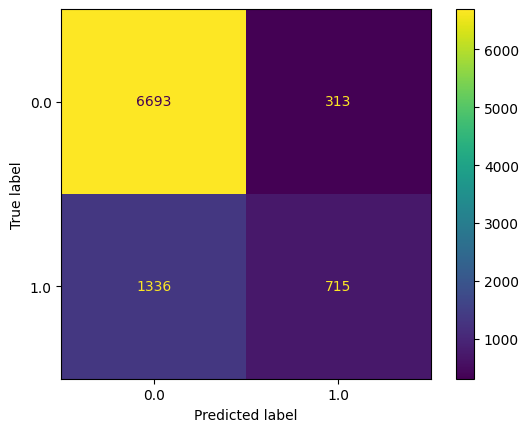

In [198]:
import numpy as np
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

y_test = np.array(pred.select('Y').collect())
y_pred = np.array(pred.select('prediction').collect())

print(classification_report(y_pred, y_test))

print(ConfusionMatrixDisplay.from_predictions(y_test, y_pred))